In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

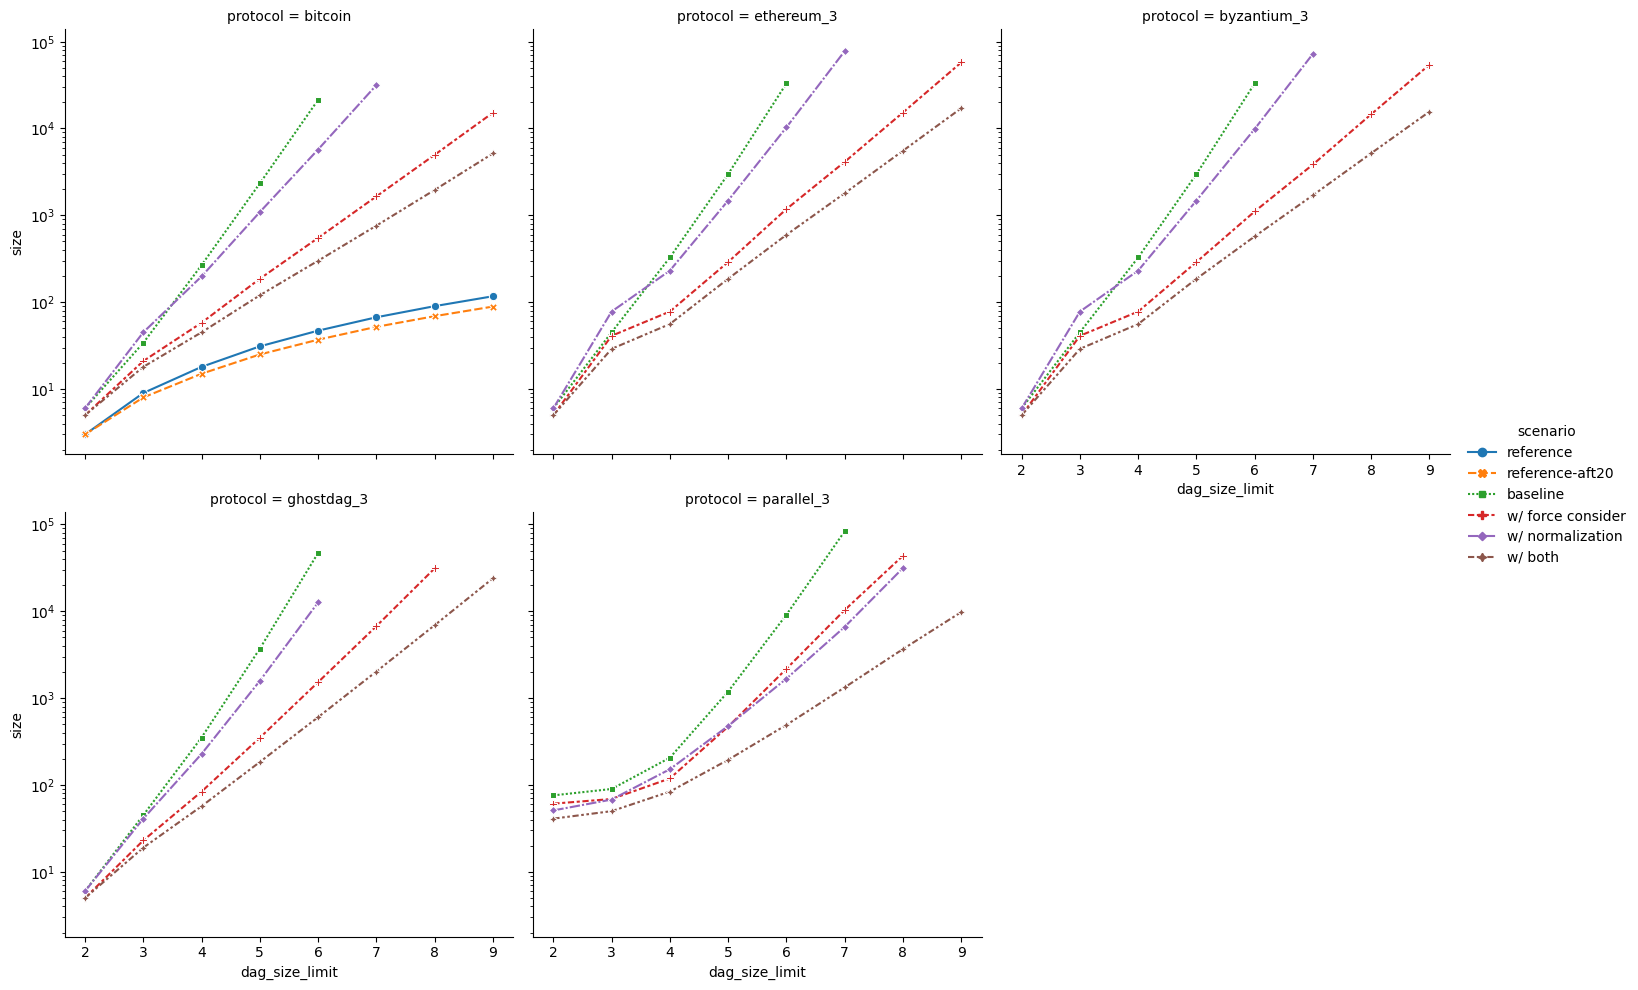

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

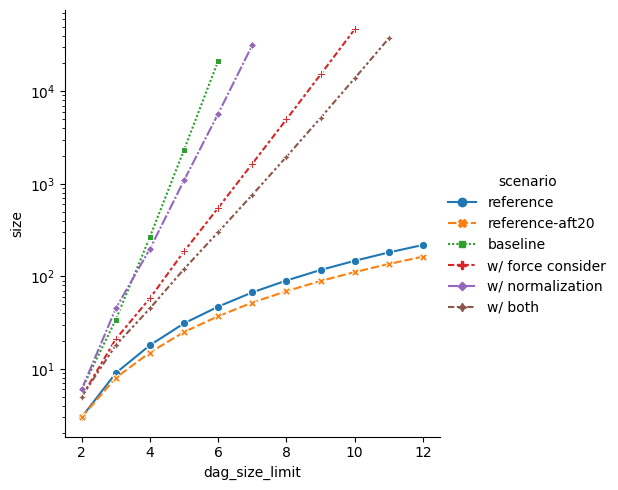

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
).set(yscale="log")

In [4]:
scenario_labels = {
    "reference": "reference-fc16",
    "reference-aft20": "reference-aft20",
    "reference-v0": "drop",
    "baseline": "baseline",
    "w/o collect garbage": "baseline-gc",
    "w/o truncate": "baseline-tc",
    "w/ force consider": "baseline+fc",
    "w/ normalization": "baseline+n",
    "w/ both": "baseline+fc+n",
}

cutoff = (
    max(size_log.query("not scenario.str.startswith('reference')").dag_size_limit) + 1
)

btc_size = (
    size_log.assign(scenario=[scenario_labels[x] for x in size_log.scenario])
    .query("scenario != 'drop'")
    .query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .pivot(index="dag_size_limit", columns="scenario", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

scenario,baseline,baseline+fc,baseline+fc+n,baseline+n,reference-aft20,reference-fc16
dag_size_limit,,,,,,
2,6.0,5.0,5.0,6.0,3.0,3.0
3,34.0,21.0,18.0,45.0,8.0,9.0
4,267.0,58.0,45.0,198.0,15.0,18.0
5,2332.0,186.0,120.0,1090.0,25.0,31.0
6,21327.0,549.0,300.0,5724.0,37.0,47.0
7,NaN,1650.0,760.0,31532.0,52.0,67.0
8,NaN,4968.0,1959.0,NaN,69.0,90.0
9,NaN,15172.0,5153.0,NaN,89.0,117.0
10,NaN,46756.0,13794.0,NaN,111.0,147.0


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["scenario", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("scenario != 'w/o collect garbage'")
    .query("scenario != 'reference-v0'")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,False,False,True,True,False,bitcoin,6,21327,17.422045,0.344986,4bb29870
1,baseline,generic_1,False,False,True,True,False,byzantium_3,6,33016,25.587397,0.445107,747a996f
2,baseline,generic_1,False,False,True,True,False,ethereum_3,6,32961,24.555598,0.444027,36b8ff99
3,baseline,generic_1,False,False,True,True,False,ghostdag_3,6,46966,42.345118,0.543316,3ab8938a
4,baseline,generic_1,False,False,True,True,False,parallel_3,7,83355,61.972259,0.935226,2ee35a1e
5,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,239,99247,4.911670,0.338615,792a6e0b
6,reference-aft20,aft20barzur,True,True,True,True,True,bitcoin,283,99688,3.473024,0.306271,6a0a9690
7,w/ both,generic_1,True,True,True,True,False,bitcoin,11,37322,57.170615,0.606430,6e7500de
8,w/ both,generic_1,True,True,True,True,False,byzantium_3,10,47341,71.943641,0.681244,53b22e78
9,w/ both,generic_1,True,True,True,True,False,ethereum_3,10,51668,70.430291,0.729233,68edc890


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("scenario != 'w/o collect garbage'")
    .query("scenario != 'reference-v0'")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,0.001620,0.173233,3b1ef8aa
1,reference-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,0.000927,0.174820,503ccebc
2,baseline,generic_1,False,False,True,True,False,bitcoin,6,21327,17.422045,0.344986,4bb29870
3,baseline,generic_1,False,False,True,True,False,ethereum_3,6,32961,24.555598,0.444027,36b8ff99
4,baseline,generic_1,False,False,True,True,False,byzantium_3,6,33016,25.587397,0.445107,747a996f
5,baseline,generic_1,False,False,True,True,False,ghostdag_3,6,46966,42.345118,0.543316,3ab8938a
6,baseline,generic_1,False,False,True,True,False,parallel_3,6,9122,5.548876,0.272751,1b1c3361
7,w/ force consider,generic_1,True,False,True,True,False,bitcoin,6,549,0.311148,0.224998,4c5b97de
8,w/ force consider,generic_1,True,False,True,True,False,ethereum_3,6,1179,0.761512,0.233868,601fa1bc
9,w/ force consider,generic_1,True,False,True,True,False,byzantium_3,6,1109,0.808308,0.237789,33fc451a


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["scenario", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["scenario", "protocol"])["size"],
    )
).reset_index()
combined

,scenario,protocol,max_dag_size_limit,size_at_fixed_dag_size
0,baseline,bitcoin,6,21327
1,baseline,byzantium_3,6,33016
2,baseline,ethereum_3,6,32961
3,baseline,ghostdag_3,6,46966
4,baseline,parallel_3,7,9122
5,reference,bitcoin,239,47
6,reference-aft20,bitcoin,283,37
7,w/ both,bitcoin,11,300
8,w/ both,byzantium_3,10,572
9,w/ both,ethereum_3,10,596


In [8]:
fixed_cutoff

6

In [9]:
combined.query('not scenario.str.startswith("reference")').set_index(
    ["scenario", "protocol"]
).unstack(level=0).stack(level=0, future_stack=True).unstack(level=1)

scenario              baseline                                   w/ both  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      6                  21327                 11   
byzantium_3                  6                  33016                 10   
ethereum_3                   6                  32961                 10   
ghostdag_3                   6                  46966                 10   
parallel_3                   7                   9122                 11   

scenario                            w/ force consider                         \
            size_at_fixed_dag_size max_dag_size_limit size_at_fixed_dag_size   
protocol                                                                       
bitcoin                        300                 10                    549   
byzantium_3                    572                  9                   1109   
ethereum_3                     596                  9                   1179   
ghostdag_3                     604                  8                   1527   
parallel_3                     492                  8                   2175   

scenario      w/ normalization                         
            max_dag_size_limit size_at_fixed_dag_size  
protocol                                               
bitcoin                      7                   5724  
byzantium_3                  7                   9879  
ethereum_3                   7                  10293  
ghostdag_3                   6                  12644  
parallel_3                   8                   1677